In [2]:
import pyjags
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pandas.tools.plotting import *

# Adapted data from Royla and Dorazio (Chapter 2)
# Moth mortality data
T = 12
K = 20 # number of moths per batch
y = np.array([1,4,9,13,18,20, 0,2,6,10,12,16]) 
sex = np.repeat('male',6), np.repeat('female',6) 
dose = (list(range(0,6)))*2
#sexcode = int(sex == 'male')
sexcode = np.array([1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0]) # I had to explicitly define sexcode here 
# The key questions is: what are the effects of dose and sex?

In [3]:
# Jags code ---------------------------------------------------------------

# Jags code to fit the model to the simulated data
code = """
model
{
  # Likelihood
  for (t in 1:T) {
  y[t] ~ dbin(p[t], K)
  logit(p[t]) <- alpha + beta_1 * x_1[t] + beta_2 * x_2[t]
  }
  
  # Priors
  alpha ~ dnorm(0.0,0.01)
  beta_1 ~ dnorm(0.0,0.01)
  beta_2 ~ dnorm(0.0,0.01)
}
"""

In [4]:
# Set up the data:
model = pyjags.Model(code, data=dict(T = T, K = K, y = y, x_1 = sexcode, x_2 = dose), chains=4) # Chains = Number of different starting positions

# Number of iterations to remove at start
model.sample(200, vars=[])

# Choose the parameters to watch and iterations:
samples = model.sample(1000, vars=['alpha', 'beta_1', 'beta_2'])

"""
Simulated results ----------------------------------------------------------------
"""
def summary(samples, varname, p=95):
    values = samples[varname]
    ci = np.percentile(values, [100-p, p])
    print('{:<6} mean = {:>5.1f}, {}% credible interval [{:>4.1f} {:>4.1f}]'.format(
      varname, np.mean(values), p, *ci))

for varname in ['alpha', 'beta_1', 'beta_2']:
    summary(samples, varname)



adapting: iterations 4000 of 4000, elapsed 0:00:00, remaining 0:00:00
sampling: iterations 800 of 800, elapsed 0:00:00, remaining 0:00:00
sampling: iterations 4000 of 4000, elapsed 0:00:00, remaining 0:00:00
alpha  mean =  -3.6, 95% credible interval [-4.3 -2.8]
beta_1 mean =   1.1, 95% credible interval [ 0.6  1.7]
beta_2 mean =   1.1, 95% credible interval [ 0.9  1.3]


/Users/alaninglis/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2963: FutureWarning: 
Panel is deprecated and will be removed in a future version.
The recommended way to represent these types of 3-dimensional data are with a MultiIndex on a DataFrame, via the Panel.to_frame() method
Alternatively, you can use the xarray package http://xarray.pydata.org/en/stable/.
Pandas provides a `.to_xarray()` method to help automate this conversion.

  exec(code_obj, self.user_global_ns, self.user_ns)


Mean:
Variable
alpha    -3.563291
beta_1    1.134835
beta_2    1.090126
dtype: float64
Credible Intervals:
Variable     alpha    beta_1    beta_2
0.05     -4.303124  0.582883  0.876305
0.95     -2.806145  1.696664  1.303619


/Users/alaninglis/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:29: FutureWarning: 'pandas.tools.plotting.autocorrelation_plot' is deprecated, import 'pandas.plotting.autocorrelation_plot' instead.


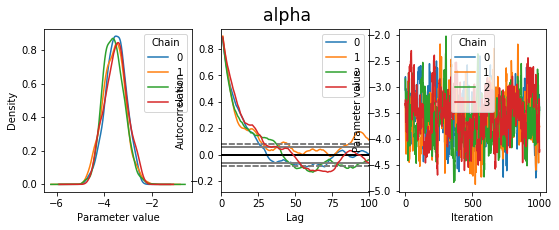

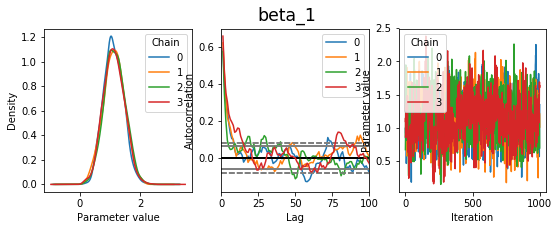

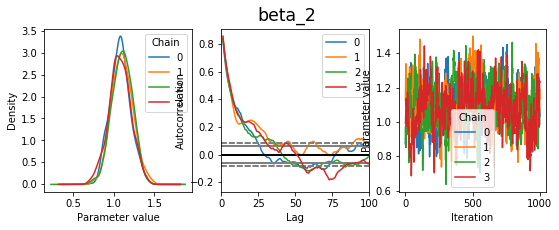

In [5]:
# Use pandas three dimensional Panel to represent the trace:
trace = pd.Panel({k: v.squeeze(0) for k, v in samples.items()})
trace.axes[0].name = 'Variable'
trace.axes[1].name = 'Iteration'
trace.axes[2].name = 'Chain'
 
# Point estimates:
print("Mean:")
print(trace.to_frame().mean()) # .to_frame converts a series to dataframe
 

# Bayesian equal-tailed 95% credible intervals:
print("Credible Intervals:")
print(trace.to_frame().quantile([0.05, 0.95]))
 

def plot(trace, var):
    fig, axes = plt.subplots(1, 3, figsize=(9, 3))
    fig.suptitle(var, fontsize='xx-large')
 
    # Marginal posterior density estimate:
    trace[var].plot.density(ax=axes[0])
    axes[0].set_xlabel('Parameter value')
    axes[0].locator_params(tight=True)
 
    # Autocorrelation for each chain:
    axes[1].set_xlim(0, 100)
    for chain in trace[var].columns:
        autocorrelation_plot(trace[var,:,chain], axes[1], label=chain)
 
    # Trace plot:
    axes[2].set_ylabel('Parameter value')
    trace[var].plot(ax=axes[2])
 
   
 # Display diagnostic plots
for var in trace:
    plot(trace, var)

In [6]:
alpha_mean = -3.576076
beta_1_mean = 1.122860
beta_2_mean = 1.096511

#plt.hist()
#plt.ylabel('Frequency');

In [7]:
o = np.argsort(model.data["x_2"]) # np.argsort() = order() in R

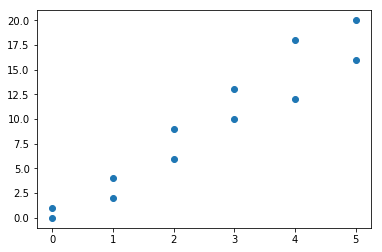

In [9]:
plt.scatter(model.data["x_2"],y)

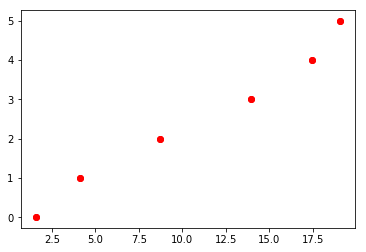

In [13]:
IL = (alpha_mean + beta_1_mean * 1 + beta_2_mean * model.data["x_2"]),
A = np.array(model.data["K"]*np.exp(IL)/(1+np.exp(IL)))
B = np.array([model.data["x_2"]])
plt.scatter(A,B, c='red')